## **Passo 1: Configurando o Google Colab para PySpark**

Primeiro, precisamos instalar e configurar o PySpark no Google Colab. Execute o código abaixo para instalar a biblioteca e iniciar uma sessão Spark:

In [1]:
!pip install pyspark faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 58.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=a10d7edc0fd0ed94dffc2dfa8563dc4cd407a5e845b90f767c6ee7b45358a214
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


Fazendo o import das bibliotecas necessárias:

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col
from faker import Faker
import pandas as pd
import matplotlib.pyplot as plt

Inicie a SparkSession:

In [3]:
spark = SparkSession.builder \
    .appName("ExemploPySpark") \
    .getOrCreate()

## **Passo 2: Mockando Dados com Faker**
Usando o Faker, podemos gerar dados fictícios para popular nosso DataFrame.

In [4]:
fake = Faker()
Faker.seed(42)  # Para garantir que os dados sejam replicáveis

# Gerando uma lista de dados simulados
data = [
    (
        fake.name(),                  # Nome
        fake.random_int(min=18, max=80),  # Idade
        fake.city(),                  # Cidade
        fake.email(),                 # E-mail
        fake.job(),                   # Profissão
        round(fake.random_number(digits=5) * 1.13, 2)  # Salário
    )
    for _ in range(10000)
]

# Criando um DataFrame PySpark com os dados mockados
df = spark.createDataFrame(data, ["Nome", "Idade", "Cidade", "Email", "Profissao", "Salario"])
df.show(5)

+-----------------+-----+---------------+--------------------+--------------------+--------+
|             Nome|Idade|         Cidade|               Email|           Profissao| Salario|
+-----------------+-----+---------------+--------------------+--------------------+--------+
|     Allison Hill|   32|    Lake Curtis|garzaanthony@exam...|Engineering geolo...|34459.35|
|  Alyssa Gonzalez|   59|  Robinsonshire|  lisa02@example.net|Pharmacist, hospital|50394.61|
| Daniel Gallagher|   24|South Colinstad|lindsay78@example...|Multimedia specia...|11670.64|
|Sandra Montgomery|   73|    Barbaraland|stanleykendra@exa...|Exhibitions offic...|14958.94|
|    Jesse Flowers|   28|    Michaelview|lynchgeorge@examp...|Financial risk an...|24201.21|
+-----------------+-----+---------------+--------------------+--------------------+--------+
only showing top 5 rows



## **Passo 3: Analisando os Dados com PySpark**
Vamos fazer uma análise rápida. Aqui, agrupamos os dados por cidade e contamos a quantidade de pessoas:

In [5]:
df_grouped = df.groupBy("Cidade").count().orderBy("count", ascending=False)
df_grouped.show(10)


+-----------------+-----+
|           Cidade|count|
+-----------------+-----+
|       West James|   13|
|       Smithmouth|   11|
|South Christopher|   11|
|     Port Michael|   10|
|     Johnsonmouth|   10|
|    East Jennifer|   10|
| West Christopher|    9|
|       Port David|    9|
|    South Michael|    9|
|     North Ashley|    9|
+-----------------+-----+
only showing top 10 rows



Agrupando por Profissão e Calculando Média Salarial

In [6]:
df_grouped2 = (
    df.groupBy("Profissao")
      .agg(avg("Salario").alias("Media"))
      .orderBy("Media", ascending=False)
)

df_grouped.show(10)

+-----------------+-----+
|           Cidade|count|
+-----------------+-----+
|       West James|   13|
|       Smithmouth|   11|
|South Christopher|   11|
|     Port Michael|   10|
|     Johnsonmouth|   10|
|    East Jennifer|   10|
| West Christopher|    9|
|       Port David|    9|
|    South Michael|    9|
|     North Ashley|    9|
+-----------------+-----+
only showing top 10 rows



Para facilitar a visualização, vamos converter para um Pandas DataFrame:



In [7]:
pandas_df = df_grouped.toPandas()
pandas_df2 = df_grouped2.toPandas()


##**Passo 4: Plotando Gráficos**
Agora, vamos visualizar os dados com Matplotlib.

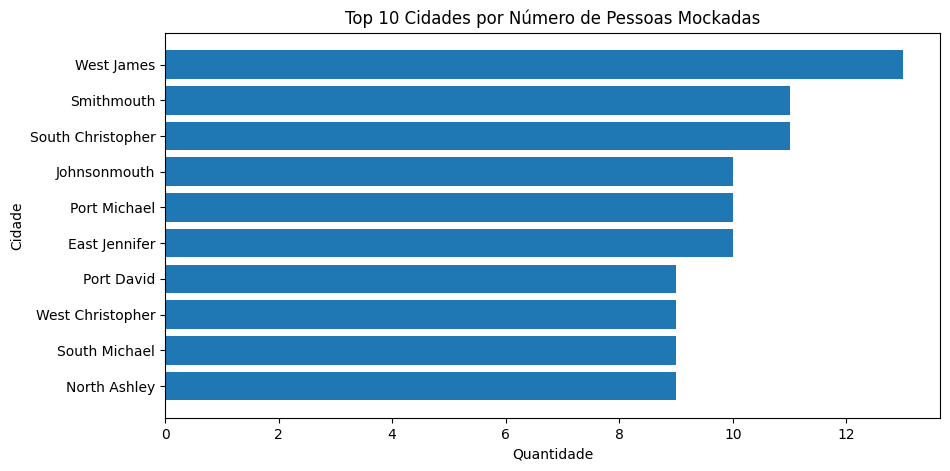

In [8]:
plt.figure(figsize=(10, 5))
plt.barh(pandas_df["Cidade"].head(10), pandas_df["count"].head(10))
plt.xlabel("Quantidade")
plt.ylabel("Cidade")
plt.title("Top 10 Cidades por Número de Pessoas Mockadas")
plt.gca().invert_yaxis()

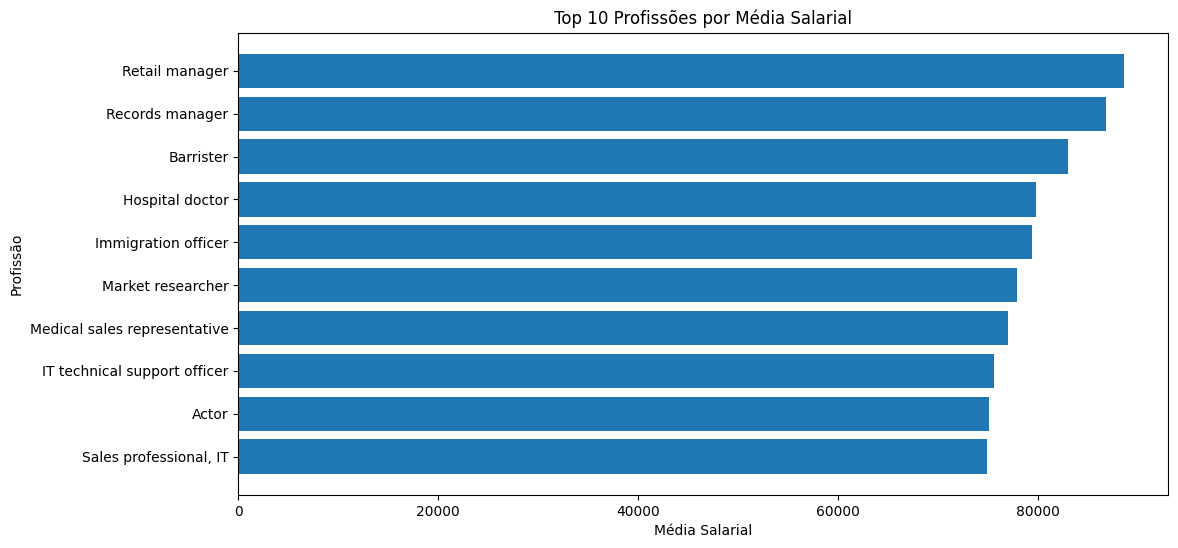

In [9]:
plt.figure(figsize=(12, 6))
plt.barh(pandas_df2["Profissao"].head(10), pandas_df2["Media"].head(10))
plt.xlabel("Média Salarial")
plt.ylabel("Profissão")
plt.title("Top 10 Profissões por Média Salarial")
plt.gca().invert_yaxis()  # Inverte o eixo Y para ordenar corretamente
plt.show()

## **Passo 5: Preparando Dados para o Modelo **

In [12]:
from pyspark.ml.feature import VectorAssembler

features = VectorAssembler(inputCols=["Idade"], outputCol="features")
df_transformed = features.transform(df).select("features", col("Salario").alias("label"))
df_transformed.show(5)

+--------+--------+
|features|   label|
+--------+--------+
|  [32.0]|34459.35|
|  [59.0]|50394.61|
|  [24.0]|11670.64|
|  [73.0]|14958.94|
|  [28.0]|24201.21|
+--------+--------+
only showing top 5 rows



## **Passo 6: Treinando um Modelo de Regressão Linear**

In [13]:
from pyspark.ml.regression import LinearRegression

# Definindo o modelo de regressão linear
lr = LinearRegression()

# Treinando o modelo
modelo = lr.fit(df_transformed)

# Exibindo os coeficientes do modelo
print(f"Coeficiente: {modelo.coefficients}")
print(f"Intercepto: {modelo.intercept}")

Coeficiente: [28.9513567689819]
Intercepto: 54591.19424963454


## **Passo 7: Avaliando o Modelo**

In [14]:
# Fazendo previsões
predicoes = modelo.transform(df_transformed)
predicoes.select("features", "label", "prediction").show(5)

# Avaliando o modelo com Root Mean Squared Error (RMSE)
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse")
rmse = evaluator.evaluate(predicoes)
print(f"RMSE: {rmse}")

+--------+--------+-----------------+
|features|   label|       prediction|
+--------+--------+-----------------+
|  [32.0]|34459.35|55517.63766624196|
|  [59.0]|50394.61|56299.32429900447|
|  [24.0]|11670.64| 55286.0268120901|
|  [73.0]|14958.94|56704.64329377021|
|  [28.0]|24201.21|55401.83223916603|
+--------+--------+-----------------+
only showing top 5 rows

RMSE: 32629.014534771766


O valor alto do RMSE indica que o modelo de regressão linear pode não estar ajustado corretamente aos dados. Isso pode ocorrer por vários motivos, como dados insuficientes ou com grande variabilidade
A relação entre a idade e o salário pode não ser linear
Falta de outras variáveis relevantes no modelo